# Description

pytorch seem to be less susceptible to overfitting as compared to tensorflow - keras.

In my previous session to implement pytorch neural network with concrete data, I found that nn with pytorch hardly overfitting the training data. 

In this script we are going to build similar nn with both keras and pytorch, to check that if keras do tend to over fitting.

## Method
We will try to build the structure as close as possible.

Initially I use default optimizers learning rate for both keras and pytorch
- Keras: Adam 0.001
- pytorch: Adam 0.001

Note on the term, 
From the entire data set we split them into training and hold out set. In some case it called Test dataset, which we use to test the final model.

The training datasets, will then further splits during training into
subsets of training and validation sets. This done as part of 'for' loop

### Mode l 
We construct a simple model for both with 5 hidden layers, and 100 nodes for each hidden layers, with 'Relu' activation function applied on all layers. In the simple model, no validation split was carried out.

### Model 2
In the second development, we split the training data into sub-training and validation. Where we measure both the training loss and validation loss.

### Model 3
We constructs routine for hyper parameters tuning.
We run the hyperparameters optimization several times to construct the neural network ensamble.
Typically each hyperparameters optimization run will give out different neural network structure.
In that way we could construct prediction statistic.

In this case we are using gp_minimize function from skopt to automatically search trough maximum R2. 
We generate 100 sets of hyper-parameters suggestion.


## Results:

### Model 1
It seems pytorch training runs much faster than keras's
Keras took about 1 minutes for 1000 epoch.
While pytorch took about 2.24s, even with similar level of verbose (keras verbose 2), it took 2.51 s


One thing to note, here, keras still use numpy array for training and fitting, while in pytorch I created the tensor as cuda directly.

with silent fitting, keras took about 1 mins.
Verbose 0: 1m 6s
Verbose 1: 1m 30s
Verbose 2: 1m 12s
verbose 3: 1m 7s

The results support that Keras tend to over-fit much easier as compared to pytorch.
 
Keras results in better $R^2$ compared to pytorch
For the simple model, Keras $R^2$ yield 0.991 and 0.934 for training and test, respectively.
For pytorch, $R^2$ yield 0.972 and 0.912 respectively

### Model 2
For keras NN, the closest score happened at about 20th iteration. Beyond that training loss decreasing while validation loss increasing.

For pytorch NN, loss for both training and validation decreasing steadily until around 30 iteration. After that it starts to diverge.

### Model 3 
It took a significant time to generate 100 sets of hp parameter suggestions.
It took about 3H, 24 mins to generate 100 models. I notice that it gave out negative $R^2$. Even with 10 training epoch. Attempt to generate 100 models ensamble froze the computer. It use up 16GB of the memmory. So only 10 first models was generated

With pytorch as the surroregate model, the hp optimization runs much faster. It took only 5 mins 45s to generate 100 hp sets. Furthermore, it gave positive R2. It range between 0.6 to 0.8. It only took 29.9 s to generate 10 models

For both Keras and PyTorch NN implementation, we did not observed either the number of hidden layers nor the number of nodes in hidden layers to be converging for the 100 runs.

<img src="ensemble.png">



![caption](ensemble.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import joblib

import sklearn
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import skopt
from skopt import gp_minimize

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, InputLayer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
today = datetime.date.today().isoformat()
plt.style.use('ggplot')

In [3]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 0 ns (started: 2021-12-29 17:19:44 +08:00)


# Load and Prep Data

In [4]:
wb = pd.ExcelFile('Concrete_Data.xls')
df = wb.parse()

time: 79 ms (started: 2021-12-29 17:19:45 +08:00)


In [5]:
## split data
data, data_hold = train_test_split(df, random_state = 10)

X = data.iloc[:,:-1].astype('float32')
y_true = data.iloc[:,-1].astype('float32')

time: 0 ns (started: 2021-12-29 17:19:48 +08:00)


In [6]:
X_hold = data_hold.iloc[:,:-1].astype('float32')
y_true_hold = data_hold.iloc[:,-1].astype('float32')

time: 15 ms (started: 2021-12-29 17:19:49 +08:00)


In [7]:
## pre transormer
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

time: 16 ms (started: 2021-12-29 17:19:52 +08:00)


## Prep Data For Keras

In [8]:
### make training data suitable for keras
X_keras = scaler.transform(X)
y_keras = np.asarray(y_true)

X_keras_hold = scaler.transform(X_hold)

time: 0 ns (started: 2021-12-29 17:19:54 +08:00)


## Prep Data for Pytorch

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Cuda Devices {}'.format(torch.cuda.get_device_name(torch.cuda.current_device())))

Using device: cuda
Cuda Devices NVIDIA GeForce RTX 3060 Laptop GPU
time: 1.52 s (started: 2021-12-29 17:19:57 +08:00)


In [10]:
X_torch = scaler.transform(X)
y_torch = np.asarray(y_true).reshape(-1,1)

X_torch = Variable(torch.tensor(X_torch, device=device))
y_torch = Variable(torch.tensor(y_torch, device=device))

time: 109 ms (started: 2021-12-29 17:19:58 +08:00)


In [137]:
X_torch_hold = scaler.transform(X_hold)
y_torch_hold = np.asarray(y_true_hold).reshape(-1,1)

X_torch_hold = Variable(torch.tensor(X_torch_hold, device=device))
y_torch_hold = Variable(torch.tensor(y_torch_hold, device=device))

time: 16 ms (started: 2021-12-29 19:30:04 +08:00)


In [11]:
n_hidden_layers = 5
n_hidden_nodes = 100
epochs = 1000

time: 0 ns (started: 2021-12-29 17:20:01 +08:00)


In [12]:
hist_dict = {} # dictionary for fitting history

time: 0 ns (started: 2021-12-29 17:20:02 +08:00)


# Model 1

## Build Keras Model

In [11]:
model_k = Sequential(name = 'keras-model')

## may or may not need input layers
#model_k.add(InputLayer(shape=(8,)))

for i in range(n_hidden_layers): # construct hidden layer
    model_k.add(Dense(n_hidden_nodes, activation='relu'))
    
model_k.add(Dense(1)) ## output layers

model_k.compile(loss= "mean_squared_error", 
                optimizer="adam", metrics=["mean_squared_error"])
    
    
model_k.fit(X_keras, y_keras, epochs=epochs, verbose=3)    

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

time: 2min 8s (started: 2021-12-29 09:46:17 +08:00)


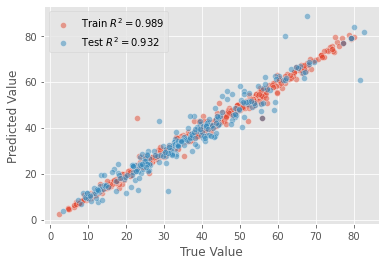

time: 984 ms (started: 2021-12-29 10:26:38 +08:00)


In [25]:
y_pred = model_k.predict(X_keras)
r2 = metrics.r2_score(y_true, y_pred)

plt.scatter(x=y_true, y=y_pred, 
            ec='w', alpha=0.5,
            label='Train $R^2=${:0.3f}'.format(r2))

y_pred_hold = model_k.predict(X_keras_hold)
r2 = metrics.r2_score(y_true_hold, y_pred_hold)

plt.scatter(x=y_true_hold, y=y_pred_hold, 
            ec='w', alpha=0.5, 
            label='Test $R^2=${:0.3f}'.format(r2))

plt.xlabel('True Value')
plt.ylabel('Predicted Value')

plt.legend()


## Pytorch Model

## Simple Pytorch Model

In [13]:
class Net(nn.Module):
    def __init__(self, n_hidden_layers):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        
        self.input = nn.Linear(8, 100)
        self.hidden = nn.Linear(100, 100)
        self.predict = nn.Linear(100, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x

time: 0 ns (started: 2021-12-29 17:20:24 +08:00)


In [22]:
model_t = Net(n_hidden_layers)
model_t.to(device)

optimizer = torch.optim.Adam(model_t.parameters()) ## SGD gave 'nan'
loss_func = nn.MSELoss()

for t in range(epochs):
    #if t%20 == 0: print('\t\t {}'.format(t))


    prediction = model_t.forward(X_torch)     
    # input x and predict based on x. 
    #it seems like the object automatically call for 'forward function'

    loss = loss_func(prediction, y_torch)

    optimizer.zero_grad()

    loss.backward()  # backpropagation
    optimizer.step() # update gradient
    print('{:}/{:}-->mse:{:0.3f}'.format(t+1, epochs, loss))

1/1000-->mse:1555.9119873046875
2/1000-->mse:1554.5458984375
3/1000-->mse:1553.0933837890625
4/1000-->mse:1551.509033203125
5/1000-->mse:1549.763916015625
6/1000-->mse:1547.83251953125
7/1000-->mse:1545.5831298828125
8/1000-->mse:1542.83935546875
9/1000-->mse:1539.4384765625
10/1000-->mse:1535.1614990234375
11/1000-->mse:1529.736083984375
12/1000-->mse:1522.8280029296875
13/1000-->mse:1514.02880859375
14/1000-->mse:1502.824462890625
15/1000-->mse:1488.590576171875
16/1000-->mse:1470.4598388671875
17/1000-->mse:1447.2943115234375
18/1000-->mse:1417.8182373046875
19/1000-->mse:1380.7396240234375
20/1000-->mse:1334.556884765625
21/1000-->mse:1277.40380859375
22/1000-->mse:1207.48876953125
23/1000-->mse:1122.930419921875
24/1000-->mse:1022.1337280273438
25/1000-->mse:904.7257080078125
26/1000-->mse:772.5109252929688
27/1000-->mse:630.76025390625
28/1000-->mse:491.22528076171875
29/1000-->mse:376.8963317871094
30/1000-->mse:324.8822937011719
31/1000-->mse:368.89764404296875
32/1000-->mse:46

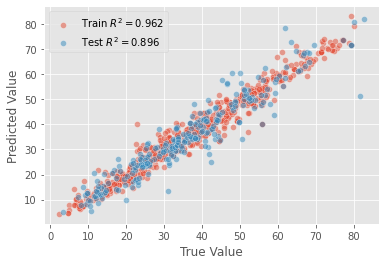

time: 907 ms (started: 2021-12-29 10:13:48 +08:00)


In [23]:
y_pred_torch = model_t.forward(X_torch)
y_pred_torch = y_pred_torch.cpu().data.numpy()

r2 = metrics.r2_score(y_true, y_pred_torch)
plt.scatter(x=y_true, y=y_pred_torch, 
            ec='w', alpha=0.5,
            label='Train $R^2=${:0.3f}'.format(r2))


X_torch_hold = scaler.transform(X_hold)
y_torch_hold = np.asarray(y_true_hold).reshape(-1,1)

X_torch_hold = Variable(torch.tensor(X_torch_hold, device=device))
y_torch_hold = Variable(torch.tensor(y_torch_hold, device=device))

y_torch_hold_pred = model_t.forward(X_torch_hold)
y_torch_hold_pred = y_torch_hold_pred.cpu().data.numpy()

r2 = metrics.r2_score(y_true_hold, y_torch_hold_pred)

plt.scatter(x=y_true_hold, y=y_torch_hold_pred, 
            ec='w', alpha=0.5, 
            label='Test $R^2=${:0.3f}'.format(r2))
''''''
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

plt.legend()


## Results

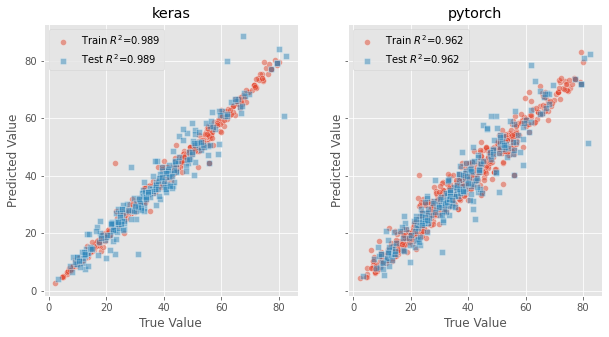

time: 203 ms (started: 2021-12-29 10:35:54 +08:00)


In [38]:
fig, axis = plt.subplots(ncols = 2, figsize = (10,5), sharex=True, sharey=True)
m_labels = ['keras', 'pytorch']
pred_ys = [y_pred, y_pred_torch]
pred_ys_hold = [y_pred_hold, y_torch_hold_pred]

for ax, pred_y, pred_y_hold, m_label in zip(axis.ravel(), pred_ys, pred_ys_hold, m_labels):
    r2 = metrics.r2_score(y_true, pred_y)
    ax.scatter(x=y_true, y=pred_y, ec='w', 
               label= 'Train $R^2$={:.3f}'.format(r2), alpha=0.5)
    
    ax.scatter(x=y_true_hold, y=pred_y_hold, ec='w', marker = 's',
               label= 'Test $R^2$={:.3f}'.format(r2), alpha=0.5)
    
    
    ax.set_title(m_label)
    ax.set_ylabel('Predicted Value')
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')

# Model 2

## Keras 2

In [39]:


model_k2 = Sequential(name = 'keras-model')

## may or may not need input layers
#model_k.add(InputLayer(shape=(8,)))

for i in range(n_hidden_layers): # construct hidden layer
    model_k2.add(Dense(n_hidden_nodes, activation='relu'))
    
model_k2.add(Dense(1)) ## output layers

model_k2.compile(loss= "mean_squared_error", 
                optimizer="adam", metrics=["mean_squared_error"])

n_splits = 10
kf = KFold(n_splits=n_splits)

for train_index, val_index in kf.split(X_keras):
    #print("TRAIN:", train_index, "TEST:", val_index)
    xx_train, xx_val = X_keras[train_index], X_keras[val_index]
    yy_train, yy_val = y_keras[train_index], y_keras[val_index]
    
    vals = (xx_val, yy_val)
    hist_dict['k2'] = model_k2.fit(xx_train, yy_train, 
                                  epochs = epochs//n_splits, verbose=2,
                                  validation_data = vals) 

Epoch 1/100
22/22 - 1s - loss: 1368.0953 - mean_squared_error: 1368.0953 - val_loss: 749.8282 - val_mean_squared_error: 749.8282
Epoch 2/100
22/22 - 0s - loss: 405.0721 - mean_squared_error: 405.0721 - val_loss: 280.3387 - val_mean_squared_error: 280.3387
Epoch 3/100
22/22 - 0s - loss: 251.5896 - mean_squared_error: 251.5896 - val_loss: 205.7745 - val_mean_squared_error: 205.7745
Epoch 4/100
22/22 - 0s - loss: 204.8106 - mean_squared_error: 204.8106 - val_loss: 177.9626 - val_mean_squared_error: 177.9626
Epoch 5/100
22/22 - 0s - loss: 182.7382 - mean_squared_error: 182.7382 - val_loss: 166.9433 - val_mean_squared_error: 166.9433
Epoch 6/100
22/22 - 0s - loss: 158.7962 - mean_squared_error: 158.7962 - val_loss: 140.8202 - val_mean_squared_error: 140.8202
Epoch 7/100
22/22 - 0s - loss: 142.9187 - mean_squared_error: 142.9187 - val_loss: 126.6101 - val_mean_squared_error: 126.6101
Epoch 8/100
22/22 - 0s - loss: 131.2496 - mean_squared_error: 131.2496 - val_loss: 117.4338 - val_mean_square

In [40]:
keys = hist_dict['k2'].history.keys()

time: 0 ns (started: 2021-12-29 10:40:06 +08:00)


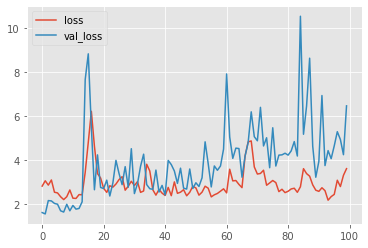

time: 94 ms (started: 2021-12-29 10:40:06 +08:00)


In [41]:
for key in ['loss', 'val_loss']:
    plt.plot(hist_dict['k2'].history[key], label=key)

plt.legend()

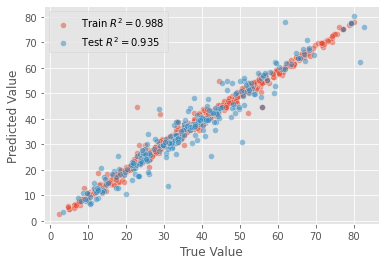

time: 1.03 s (started: 2021-12-29 10:42:03 +08:00)


In [42]:
y_pred2 = model_k2.predict(X_keras)
r2 = metrics.r2_score(y_true, y_pred2)
plt.scatter(x=y_true, y=y_pred2, 
            ec='w', alpha=0.5,
            label='Train $R^2=${:0.3f}'.format(r2))

y_pred_hold2 =  model_k2.predict(X_keras_hold)

r2 = metrics.r2_score(y_true_hold, y_pred_hold2)

plt.scatter(x=y_true_hold, y=y_pred_hold2, 
            ec='w', alpha=0.5, 
            label='Test $R^2=${:0.3f}'.format(r2))

plt.xlabel('True Value')
plt.ylabel('Predicted Value')

plt.legend()


## Pytorch 2

In [14]:
class Net2(nn.Module):
    def __init__(self, n_hidden_layers):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net2, self).__init__() ## inherit init function from the ancestor
        
        
        self.input = nn.Linear(8, 100)
        self.hidden = nn.Linear(100, 100)
        self.predict = nn.Linear(100, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, validation_data = None, epochs=100, verbose=True):
        """
        validation_data: touple of x_val and y_val
        """
        
        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()

        history = {}
        
        history['loss'] = []
        if validation_data != None: history['val_loss'] = []
        
        for t in range(epochs):

            prediction = self.forward(x)     
    
            loss = loss_func(prediction, y)

            optimizer.zero_grad()

            loss.backward()  # backpropagation
            optimizer.step() # update gradient
            
            history['loss'].append(loss)
            if verbose: 
                if validation_data ==None:
                    print('{:}/{:}-->mse:{:0.3f}'.format(t+1, epochs, loss))
                    
                else:
                    
                    x_val, y_val = validation_data
                    val_loss = loss_func(self.forward(x_val), y_val)
                    
                    history['val_loss'].append(val_loss)
                    
                    print('{:}/{:}-- loss: {:0.3f} val_loss: {:.3f}'.format(t+1, epochs, loss, val_loss))
        
        
        #transfer from gpu to cpu
        for key in history.keys():
            history[key] = np.hstack([x.cpu().data.numpy() for x in history[key] ])
            
            
        return history
    
    

time: 0 ns (started: 2021-12-29 17:20:37 +08:00)


In [44]:
model_t2 = Net2(n_hidden_layers)
model_t2.to(device)

Net2(
  (input): Linear(in_features=8, out_features=100, bias=True)
  (hidden): Linear(in_features=100, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)

time: 765 ms (started: 2021-12-29 10:44:02 +08:00)


In [45]:
for train_index, val_index in kf.split(X_torch):
    #print("TRAIN:", train_index, "TEST:", val_index)
    xx_train, xx_val = X_torch[train_index], X_torch[val_index]
    yy_train, yy_val = y_torch[train_index], y_torch[val_index]
    
    vals = (xx_val, yy_val)
    hist_dict['t2'] = model_t2.fit(xx_train, yy_train, 
                                  epochs = epochs//n_splits, verbose=2,
                                  validation_data = vals) 

1/100-- loss: 1568.655 val_loss: 1472.036
2/100-- loss: 1567.202 val_loss: 1470.672
3/100-- loss: 1565.787 val_loss: 1469.282
4/100-- loss: 1564.356 val_loss: 1467.879
5/100-- loss: 1562.911 val_loss: 1466.430
6/100-- loss: 1561.411 val_loss: 1464.871
7/100-- loss: 1559.802 val_loss: 1463.178
8/100-- loss: 1558.052 val_loss: 1461.303
9/100-- loss: 1556.111 val_loss: 1459.161
10/100-- loss: 1553.891 val_loss: 1456.653
11/100-- loss: 1551.285 val_loss: 1453.688
12/100-- loss: 1548.206 val_loss: 1450.169
13/100-- loss: 1544.552 val_loss: 1445.985
14/100-- loss: 1540.190 val_loss: 1440.874
15/100-- loss: 1534.858 val_loss: 1434.532
16/100-- loss: 1528.240 val_loss: 1426.605
17/100-- loss: 1519.946 val_loss: 1416.711
18/100-- loss: 1509.579 val_loss: 1404.337
19/100-- loss: 1496.614 val_loss: 1388.971
20/100-- loss: 1480.474 val_loss: 1369.829
21/100-- loss: 1460.316 val_loss: 1346.062
22/100-- loss: 1435.228 val_loss: 1316.583
23/100-- loss: 1404.033 val_loss: 1280.151
24/100-- loss: 1365.

In [46]:
hist_dict['t2']['loss']

array([14.210277 , 59.281445 , 26.287033 , 41.98413  , 20.143316 ,
       21.15514  , 31.984018 , 27.397245 , 18.429348 , 19.4322   ,
       24.064674 , 20.598106 , 15.292179 , 16.477055 , 20.570227 ,
       20.696404 , 17.259737 , 15.387115 , 16.756716 , 17.439775 ,
       15.782912 , 14.750366 , 15.908402 , 16.968689 , 16.049149 ,
       14.620887 , 14.679299 , 15.436508 , 15.115681 , 14.329007 ,
       14.537364 , 15.153923 , 14.89666  , 14.151941 , 14.079615 ,
       14.506025 , 14.401459 , 13.994992 , 14.073955 , 14.345214 ,
       14.161783 , 13.841836 , 13.889652 , 14.019905 , 13.886079 ,
       13.773137 , 13.910198 , 13.899574 , 13.704986 , 13.6621065,
       13.766168 , 13.732399 , 13.625084 , 13.658164 , 13.677274 ,
       13.581248 , 13.555157 , 13.591179 , 13.55745  , 13.516708 ,
       13.546029 , 13.520589 , 13.465179 , 13.461573 , 13.471513 ,
       13.438492 , 13.41698  , 13.419225 , 13.391413 , 13.373533 ,
       13.371858 , 13.357273 , 13.331776 , 13.330619 , 13.3167

time: 0 ns (started: 2021-12-29 10:44:38 +08:00)


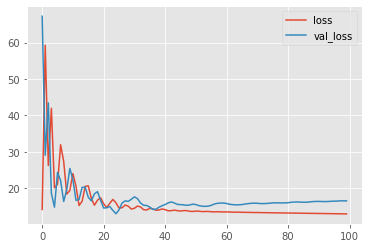

time: 94 ms (started: 2021-12-29 10:44:42 +08:00)


In [47]:
for key in ['loss', 'val_loss']:
    plt.plot(hist_dict['t2'][key], label=key)

plt.legend()

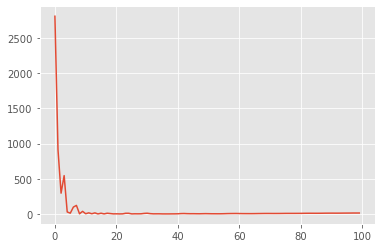

time: 78 ms (started: 2021-12-29 10:44:49 +08:00)


In [48]:
delta = hist_dict['t2']['loss'] - hist_dict['t2']['val_loss']
plt.plot(delta**2)

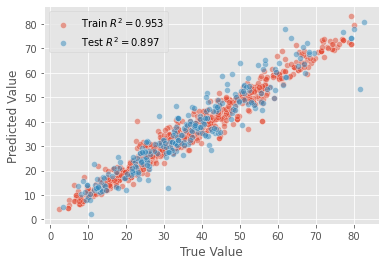

time: 875 ms (started: 2021-12-29 10:46:14 +08:00)


In [50]:
y_pred_torch2 = model_t2.forward(X_torch)
y_pred_torch2 = y_pred_torch2.cpu().data.numpy()

r2 = metrics.r2_score(y_true, y_pred_torch2)
plt.scatter(x=y_true, y=y_pred_torch, 
            ec='w', alpha=0.5,
            label='Train $R^2=${:0.3f}'.format(r2))




y_torch_hold_pred2 = model_t2.forward(X_torch_hold)
y_torch_hold_pred2 = y_torch_hold_pred2.cpu().data.numpy()

r2 = metrics.r2_score(y_true_hold, y_torch_hold_pred2)

plt.scatter(x=y_true_hold, y=y_torch_hold_pred2, 
            ec='w', alpha=0.5, 
            label='Test $R^2=${:0.3f}'.format(r2))
''''''
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

plt.legend()


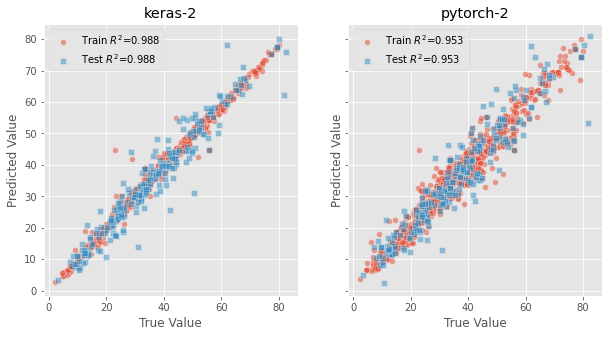

time: 218 ms (started: 2021-12-29 10:47:19 +08:00)


In [51]:
fig, axis = plt.subplots(ncols = 2, figsize = (10,5), sharex=True, sharey=True)
m_labels = ['keras-2', 'pytorch-2']
pred_ys = [y_pred2, y_pred_torch2]
pred_ys_hold = [y_pred_hold2, y_torch_hold_pred2]

for ax, pred_y, pred_y_hold, m_label in zip(axis.ravel(), pred_ys, pred_ys_hold, m_labels):
    r2 = metrics.r2_score(y_true, pred_y)
    ax.scatter(x=y_true, y=pred_y, ec='w', 
               label= 'Train $R^2$={:.3f}'.format(r2), alpha=0.5)
    
    ax.scatter(x=y_true_hold, y=pred_y_hold, ec='w', marker = 's',
               label= 'Test $R^2$={:.3f}'.format(r2), alpha=0.5)
    
    
    ax.set_title(m_label)
    ax.set_ylabel('Predicted Value')
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')

# Model 3

## Keras 3

In [15]:
## create function to create keras model
def make_kmodel(n_hidden_layers, n_hidden_nodes, verbose=0):
    
    model = Sequential(name = 'keras-model')



    for i in range(n_hidden_layers): # construct hidden layer
        model.add(Dense(n_hidden_nodes, activation='relu'))

    model.add(Dense(1)) ## output layers

    model.compile(loss= "mean_squared_error", 
                    optimizer="adam", metrics=["mean_squared_error"])

    n_splits = 10
    kf = KFold(n_splits=n_splits)

    for train_index, val_index in kf.split(X_keras):
        #print("TRAIN:", train_index, "TEST:", val_index)
        xx_train, xx_val = X_keras[train_index], X_keras[val_index]
        yy_train, yy_val = y_keras[train_index], y_keras[val_index]

        vals = (xx_val, yy_val)
        hist = model.fit(xx_train, yy_train, 
                            epochs = epochs//n_splits, verbose=verbose,
                            validation_data = vals) 
    return model

time: 0 ns (started: 2021-12-29 17:20:58 +08:00)


In [16]:
# create minimization function to fed to gp_minimize
def func_k(input_array):
    n_hidden_layers, n_hidden_nodes = input_array
    
    model = make_kmodel(n_hidden_layers, n_hidden_nodes)
    
    r2 = metrics.r2_score(y_true, model.predict(X))
    
    return -r2

time: 0 ns (started: 2021-12-29 17:21:01 +08:00)


time: 0 ns (started: 2021-12-29 17:21:03 +08:00)


In [77]:
res_kdict ={}

time: 0 ns (started: 2021-12-29 12:27:47 +08:00)


In [81]:
n_models = 100
for i in range(n_models):
    print('{:}/{:} started ----------------------'.format(i, n_models))
    res_kdict[i] = gp_minimize(func_k, bounds, verbose=True, initial_point_generator = 'lhs', n_calls = 10, n_jobs = 10)
    print('{:}/{:} end ----------------------\n\n'.format(i, n_models))

0/100 started ----------------------
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.5241
Function value obtained: 130841.6915
Current minimum: 130841.6915
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.6861
Function value obtained: 56423.3752
Current minimum: 56423.3752
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.4353
Function value obtained: 319433.3437
Current minimum: 56423.3752
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.2731
Function value obtained: 62221.7869
Current minimum: 56423.3752
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 12.6748
Function value 

In [82]:
joblib.dump(res_kdict, 'res_kdict_{}.joblib'.format(today))

['res_kdict_2021-12-29.joblib']

time: 234 ms (started: 2021-12-29 15:58:00 +08:00)


In [18]:
res_kdict = joblib.load('res_kdict_{}.joblib'.format(today))

time: 140 ms (started: 2021-12-29 17:21:45 +08:00)


In [19]:
n_models = 100
for i in range(10):
    print('depth nodes: {}, loss: {:0.3f}'.format(res_kdict[i].x, res_kdict[i].fun))

depth nodes: [13, 150], loss: 679.948
depth nodes: [19, 151], loss: 3656.611
depth nodes: [17, 111], loss: 724.791
depth nodes: [20, 173], loss: 34127.655
depth nodes: [17, 152], loss: 18709.673
depth nodes: [15, 151], loss: 4106.367
depth nodes: [18, 116], loss: 462.415
depth nodes: [18, 88], loss: 4.257
depth nodes: [16, 186], loss: 2186.525
depth nodes: [14, 11], loss: 4.017
time: 0 ns (started: 2021-12-29 17:22:11 +08:00)


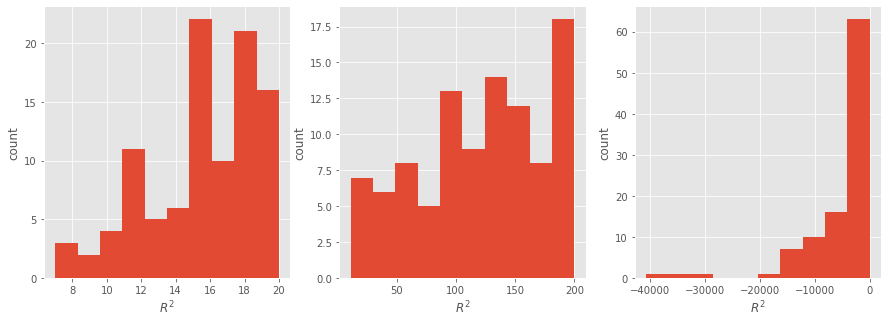

time: 250 ms (started: 2021-12-29 16:28:59 +08:00)


In [101]:
## plot depth distribution
fig, axis = plt.subplots(ncols=3, figsize=(15,5))
depths = [res_kdict[i].x[0] for i in range(n_models)]
nodes = [res_kdict[i].x[1] for i in range(n_models)]
funs = [-res_kdict[i].fun for i in range(n_models)]

labels = ['depth', 'nodes', 'loss']

for ax, hp, l in zip(axis.ravel(), [depths, nodes, funs], labels):
    ax.hist(hp)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('count')

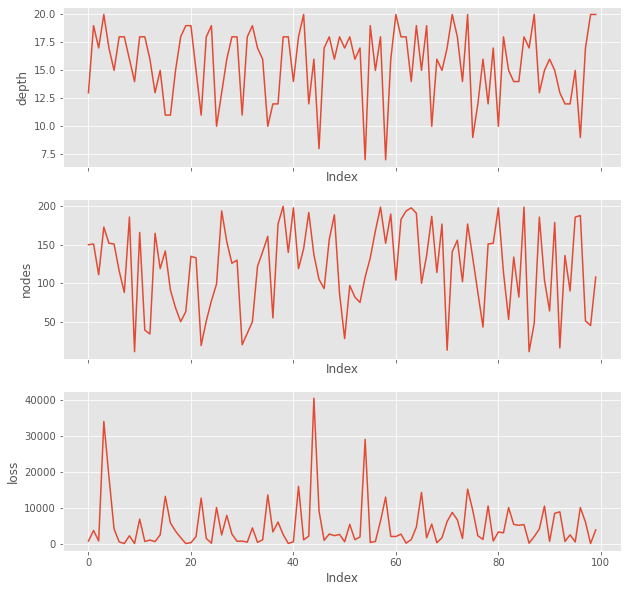

time: 469 ms (started: 2021-12-29 16:17:43 +08:00)


In [99]:
fig, axis = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
for ax, hp, l in zip(axis.ravel(), [depths, nodes, funs], labels):
    ax.plot(hp)
    ax.set_xlabel('Index')
    ax.set_ylabel(l)

In [20]:
### let's generate 100 models
models3 = {}

for i in range(10):
    print(i)
    n_hidden_layers, n_hidden_nodes = res_kdict[i].x
    models3[i] = make_kmodel(n_hidden_layers, n_hidden_nodes, verbose=0)

0
1
2
3
4
5
6
7
8
9
time: 24min 38s (started: 2021-12-29 17:22:29 +08:00)


In [21]:
for i in range(10):
    models3[i].save('keras3_{}.h5'.format(i))

time: 703 ms (started: 2021-12-29 18:05:07 +08:00)


In [153]:
y_preds3 = {}
y_preds_hold3 = {}

for i in range(10):
    y_preds3[i] = models3[i].predict(X_keras)
    y_preds_hold3[i] = models3[i].predict(X_keras_hold)
    

time: 1.27 s (started: 2021-12-29 19:35:26 +08:00)


In [154]:
df_preds = pd.DataFrame(index = y_true.index)
df_preds_hold = pd.DataFrame(index = y_true_hold.index)
for i in range(10):
    df_preds[i] = y_preds3[i][:,0]
    df_preds_hold[i] = y_preds_hold3[i][:,0]

time: 0 ns (started: 2021-12-29 19:35:28 +08:00)


In [155]:
df_preds

,0,1,2,3,4,5,6,7,8,9
504,30.621424,29.512604,34.274376,33.532925,26.998489,29.842102,31.540403,30.113010,29.562757,32.073330
483,57.817993,59.231873,59.302139,56.117115,59.790405,59.923805,57.181183,58.714638,58.702553,58.064548
794,26.620111,26.671745,27.985710,26.281961,25.836578,27.079866,27.194853,26.790216,26.433624,27.210037
174,73.693016,77.178612,75.629555,71.847397,77.954819,77.471382,72.605690,75.797333,75.724266,75.535080
623,12.668716,12.213746,12.228292,12.671058,12.901417,12.179370,11.266068,12.636317,12.051290,10.283716
...,...,...,...,...,...,...,...,...,...,...
40,50.327354,51.228298,51.315247,47.913830,52.012138,51.689404,49.730358,49.836327,51.315834,52.812370
490,30.426489,38.765503,38.899292,30.650185,24.221212,32.202034,34.839355,33.442265,26.324497,33.135189
256,33.243717,31.549995,32.474895,34.035316,32.533684,32.338112,31.547895,33.065716,32.927780,35.579166
733,29.331717,32.865772,32.362854,31.651569,29.878576,32.464409,30.958336,32.874416,33.805912,26.701530


time: 16 ms (started: 2021-12-29 19:35:29 +08:00)


In [156]:
df_dist = df_preds.T.describe().T
df_dist_hold = df_preds_hold.T.describe().T

time: 1.02 s (started: 2021-12-29 19:35:30 +08:00)


In [157]:
df_dist

,count,mean,std,min,25%,50%,75%,max
504,10.0,30.807140,2.128387,26.998489,29.632594,30.367217,31.940098,34.274376
483,10.0,58.484627,1.203160,56.117115,57.879632,58.708595,59.284573,59.923805
794,10.0,26.810471,0.595059,25.836578,26.480246,26.730981,27.166106,27.985710
174,10.0,75.343719,2.044679,71.847397,74.153532,75.676910,76.833292,77.954819
623,10.0,12.109999,0.789574,10.283716,12.083310,12.221019,12.660617,12.901417
...,...,...,...,...,...,...,...,...
40,10.0,50.818115,1.400311,47.913830,49.959084,51.271772,51.596011,52.812370
490,10.0,32.290600,4.726028,24.221212,30.482413,32.668612,34.490083,38.899292
256,10.0,32.929626,1.196559,31.547895,32.372308,32.730732,33.199217,35.579166
733,10.0,31.289511,2.133731,26.701530,30.148516,32.007212,32.765431,33.805912


time: 15 ms (started: 2021-12-29 19:35:31 +08:00)


Text(0.5, 1.0, 'Keras 3')

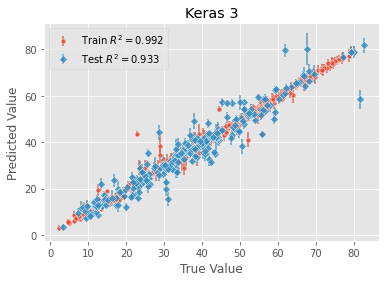

time: 125 ms (started: 2021-12-29 19:35:46 +08:00)


In [159]:
r2 = metrics.r2_score(y_true, df_dist['mean'])

plt.errorbar(x=y_true, y=df_dist['mean'], yerr = df_dist['std'], ls='', 
             marker='o', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Train $R^2=${:.3f}'.format(r2)
            )


r2 = metrics.r2_score(y_true_hold, df_dist_hold['mean'])
plt.errorbar(x=y_true_hold, y=df_dist_hold['mean'], yerr = df_dist_hold['std'], ls='', 
             marker='D', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Test $R^2=${:.3f}'.format(r2)
            )

plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend(loc='upper left')

plt.title('Keras 3')

## pytorch 3

In [108]:
class Net3(nn.Module):
    def __init__(self, n_hidden_layers, n_hidden_nodes):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net3, self).__init__() ## inherit init function from the ancestor
        
        
        self.input = nn.Linear(8, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.predict = nn.Linear(n_hidden_nodes, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, validation_data = None, epochs=100, verbose=True):
        """
        validation_data: touple of x_val and y_val
        """
        
        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()

        history = {}
        
        history['loss'] = []
        if validation_data != None: history['val_loss'] = []
        
        for t in range(epochs):

            prediction = self.forward(x)     
    
            loss = loss_func(prediction, y)

            optimizer.zero_grad()

            loss.backward()  # backpropagation
            optimizer.step() # update gradient
            
            
            if verbose: 
                if validation_data ==None:
                    print('{:}/{:}-->mse:{:0.3f}'.format(t+1, epochs, loss))
                    
                else:
                    
                    x_val, y_val = validation_data
                    val_loss = loss_func(self.forward(x_val), y_val)
                    
                    
                    
                    print('\t{:}/{:}-- loss: {:0.3f} val_loss: {:.3f}'.format(t+1, epochs, loss, val_loss))
        
        
       
    

time: 0 ns (started: 2021-12-29 19:03:19 +08:00)


In [119]:
def make_tmodel(n_hidden_layers, n_hidden_nodes, verbose=False):
    
    model = Net3(n_hidden_layers, n_hidden_nodes)
    model.to(device)


    
    n_splits = 10
    kf = KFold(n_splits=n_splits)

    for train_index, val_index in kf.split(X_torch):
        #print("TRAIN:", train_index, "TEST:", val_index)
        xx_train, xx_val = X_torch[train_index], X_torch[val_index]
        yy_train, yy_val = y_torch[train_index], y_torch[val_index]

        vals = (xx_val, yy_val)
        model.fit(xx_train, yy_train, 
                                      epochs = epochs//n_splits, verbose=False,
                                      validation_data = vals) 
    return model

time: 0 ns (started: 2021-12-29 19:15:46 +08:00)


In [115]:
# create minimization function to fed to gp_minimize
def func_t(input_array):
    n_hidden_layers, n_hidden_nodes = input_array
    
    model = make_tmodel(n_hidden_layers, n_hidden_nodes)
    prediction = model.forward(X_torch)
    prediction = prediction.cpu().data.numpy()
    r2 = metrics.r2_score(y_true, prediction)
    
    return -r2

time: 0 ns (started: 2021-12-29 19:06:28 +08:00)


In [116]:
res_tdict = {}

time: 0 ns (started: 2021-12-29 19:06:29 +08:00)


In [117]:
n_models = 100
for i in range(n_models):
    print('{:}/{:} started ----------------------'.format(i, n_models))
    res_tdict[i] = gp_minimize(func_t, bounds, verbose=False, initial_point_generator = 'lhs', n_calls = 10, n_jobs = 10)
    print('{:}/{:} end ----------------------\n\n'.format(i, n_models))

0/100 started ----------------------
0/100 end ----------------------


1/100 started ----------------------
1/100 end ----------------------


2/100 started ----------------------
2/100 end ----------------------


3/100 started ----------------------
3/100 end ----------------------


4/100 started ----------------------
4/100 end ----------------------


5/100 started ----------------------
5/100 end ----------------------


6/100 started ----------------------
6/100 end ----------------------


7/100 started ----------------------
7/100 end ----------------------


8/100 started ----------------------
8/100 end ----------------------


9/100 started ----------------------
9/100 end ----------------------


10/100 started ----------------------
10/100 end ----------------------


11/100 started ----------------------
11/100 end ----------------------


12/100 started ----------------------
12/100 end ----------------------


13/100 started ----------------------
13/100 end ---------

In [126]:
for i in range(n_models):
    print(res_tdict[i].x, res_tdict[i].fun)

[4, 92] -0.7087838932162649
[5, 76] -0.6030207893398469
[10, 164] -0.6769257100509147
[6, 178] -0.7376356654414347
[2, 156] -0.7028975858419912
[4, 158] -0.6807424293795579
[6, 153] -0.6968969716350617
[4, 106] -0.7027264705910896
[5, 79] -0.647400528630068
[10, 145] -0.7008011825893978
[5, 199] -0.7617622007658331
[4, 161] -0.7698594797868263
[6, 175] -0.7470654110594162
[6, 154] -0.7092353631931195
[3, 126] -0.7229655237672779
[4, 146] -0.7105629857987881
[2, 113] -0.6370626246966734
[4, 173] -0.7322256311110393
[7, 153] -0.7221984789236469
[8, 139] -0.731011545722561
[5, 168] -0.6854024756329282
[4, 169] -0.7255506460539225
[4, 150] -0.7242302225905117
[13, 127] -0.7226255275005002
[4, 178] -0.7317437835891316
[2, 154] -0.711325431292251
[2, 165] -0.6908051407773379
[3, 135] -0.6886910784433875
[4, 183] -0.7070390921064884
[6, 177] -0.7248181046372568
[9, 126] -0.6911535318170723
[12, 185] -0.6815901516000427
[6, 190] -0.7204772034700837
[2, 186] -0.7274970225976257
[3, 158] -0.7506

Text(0.5, 0.98, 'PyTorch Ensamble')

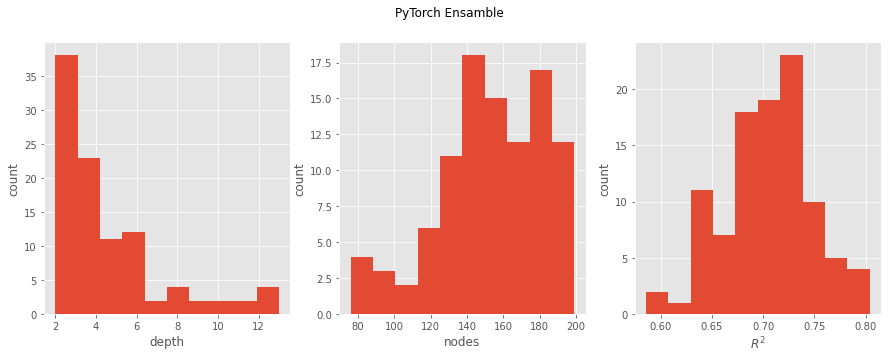

time: 266 ms (started: 2021-12-29 19:24:28 +08:00)


In [131]:
## plot depth distribution
fig, axis = plt.subplots(ncols=3, figsize=(15,5))
depths = [res_tdict[i].x[0] for i in range(n_models)]
nodes = [res_tdict[i].x[1] for i in range(n_models)]
funs = [-res_tdict[i].fun for i in range(n_models)]

labels = ['depth', 'nodes', '$R^2$']

for ax, hp, l in zip(axis.ravel(), [depths, nodes, funs], labels):
    ax.hist(hp)
    ax.set_xlabel(l)
    ax.set_ylabel('count')
fig.suptitle('PyTorch Ensamble')

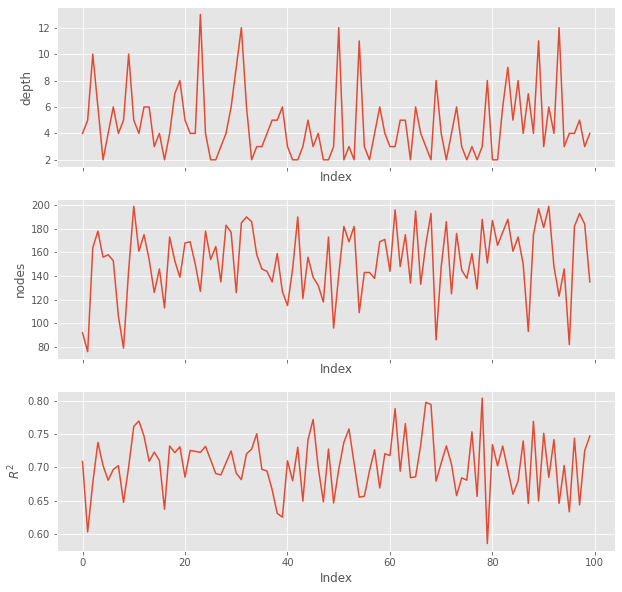

time: 250 ms (started: 2021-12-29 19:24:55 +08:00)


In [132]:
fig, axis = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
for ax, hp, l in zip(axis.ravel(), [depths, nodes, funs], labels):
    ax.plot(hp)
    ax.set_xlabel('Index')
    ax.set_ylabel(l)

In [120]:
joblib.dump(res_tdict, 'res_tdict_{}.joblib'.format(today))

['res_tdict_2021-12-29.joblib']

time: 218 ms (started: 2021-12-29 19:17:04 +08:00)


In [121]:
### let's generate 100 models
models_torch3 = {}

for i in range(10):
    print(i)
    n_hidden_layers, n_hidden_nodes = res_tdict[i].x
    models_torch3[i] = make_tmodel(n_hidden_layers, n_hidden_nodes, verbose=True)

0
1
2
3
4
5
6
7
8
9
time: 21.9 s (started: 2021-12-29 19:17:55 +08:00)


In [160]:
models_torch3[i]

Net3(
  (input): Linear(in_features=8, out_features=145, bias=True)
  (hidden): Linear(in_features=145, out_features=145, bias=True)
  (predict): Linear(in_features=145, out_features=1, bias=True)
)

time: 0 ns (started: 2021-12-29 19:36:08 +08:00)


In [161]:
y_preds_torch3 = {}
y_preds_hold_torch3 = {}

for i in range(10):
    prediction = models_torch3[i].forward(X_torch)
    prediction = prediction.cpu().data.numpy()
    y_preds_torch3[i] = prediction 
    
    prediction = models_torch3[i].forward(X_torch_hold)
    prediction = prediction.cpu().data.numpy()
    y_preds_hold_torch3[i] = prediction

time: 15 ms (started: 2021-12-29 19:36:23 +08:00)


In [165]:
df_preds_torch = pd.DataFrame(index = y_true.index)
df_preds_hold_torch = pd.DataFrame(index = y_true_hold.index)
for i in range(10):
    df_preds_torch[i] = y_preds_torch3[i][:,0]
    df_preds_hold_torch[i] = y_preds_hold_torch3[i][:,0]

time: 0 ns (started: 2021-12-29 19:38:33 +08:00)


In [166]:
df_dist_torch = df_preds_torch.T.describe().T
df_dist_hold_torch = df_preds_hold_torch.T.describe().T

time: 1.28 s (started: 2021-12-29 19:38:34 +08:00)


Text(0.5, 1.0, 'PyTorch 3')

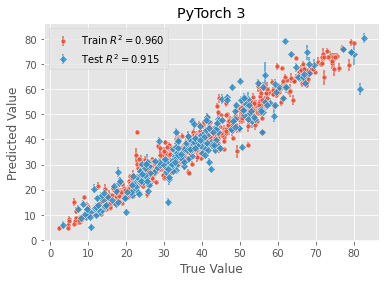

time: 156 ms (started: 2021-12-29 19:38:36 +08:00)


In [167]:
r2 = metrics.r2_score(y_true, df_dist_torch['mean'])

plt.errorbar(x=y_true, y=df_dist_torch['mean'], yerr = df_dist_torch['std'], ls='', 
             marker='o', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Train $R^2=${:.3f}'.format(r2)
            )


r2 = metrics.r2_score(y_true_hold, df_dist_hold_torch['mean'])
plt.errorbar(x=y_true_hold, y=df_dist_hold_torch['mean'], yerr = df_dist_hold_torch['std'], ls='', 
             marker='D', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Test $R^2=${:.3f}'.format(r2)
            )

plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend(loc='upper left')

plt.title('PyTorch 3')

## Results

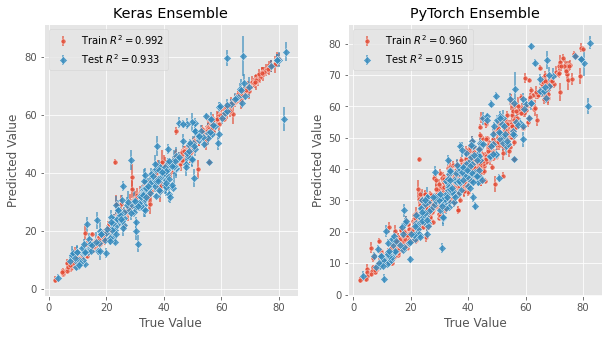

time: 234 ms (started: 2021-12-29 19:45:01 +08:00)


In [171]:
fig, axis = plt.subplots(ncols=2, figsize=(10,5))

dfs = [df_dist, df_dist_torch]
dfs_hold =[df_dist_hold, df_dist_hold_torch]
labels = ['Keras Ensemble', 'PyTorch Ensemble']

for ax, dx, dx_hold, l, in zip(axis.ravel(), dfs, dfs_hold, labels):
    r2 = metrics.r2_score(y_true, dx['mean'])

    ax.errorbar(x=y_true, y=dx['mean'], yerr = dx['std'], ls='', 
             marker='o', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Train $R^2=${:.3f}'.format(r2)
            )


    r2 = metrics.r2_score(y_true_hold, dx_hold['mean'])
    ax.errorbar(x=y_true_hold, y=dx_hold['mean'], yerr = dx_hold['std'], ls='', 
             marker='D', mec='w', alpha=0.8, mew = 0.5, ms = 5,
             label='Test $R^2=${:.3f}'.format(r2)
            )

    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')
    ax.legend(loc='upper left')

    ax.set_title(l)